In [1]:
import wandb
api = wandb.Api()

import numpy as np
import pandas as pd

import tqdm
from functools import reduce
from itertools import product
from collections import defaultdict
from tqdm.contrib.itertools import product as tqdm_product

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
best_classical = {"date":"20231207_180000", "gnn_out":1024}
result_date    = ["20231105", "20231109", "20231110", "20231112", "20231117", best_classical["date"]]

count_data  = defaultdict(int)
for run in api.runs("ntuyianchen/g_main"):
    check_date  = reduce(lambda x, y: x or y in run.name, [False]+result_date)
    if run.state == "finished" and check_date and run.summary["epoch"] == 30:
        if "QuantumRotQCGNN" in run.name and "gl1" not in run.name:
            continue
        model = run.name.split()[0] + " | " + run.config["abbrev"]
        count_data[model] += 1

count_data

defaultdict(int,
            {'Classical2PCGNN_go3_gh3_gl2_mh0_ml0 | TT-QCD': 10,
             'Classical2PCGNN_go3_gh3_gl2_mh0_ml0 | BB-QCD': 10,
             'Classical2PCGNN_go9_gh9_gl2_mh0_ml0 | TT-QCD': 10,
             'Classical2PCGNN_go9_gh9_gl2_mh0_ml0 | BB-QCD': 10,
             'Classical2PCGNN_go6_gh6_gl2_mh0_ml0 | TT-QCD': 10,
             'Classical2PCGNN_go6_gh6_gl2_mh0_ml0 | BB-QCD': 10,
             'Classical2PCGNN_go1024_gh1024_gl4_mh0_ml0 | TT-QCD': 10,
             'Classical2PCGNN_go1024_gh1024_gl4_mh0_ml0 | BB-QCD': 10,
             'QuantumRotQCGNN_qidx3_qnn6_gl1_gr9 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn6_gl1_gr6 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn6_gl1_gr3 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn9_gl1_gr6 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn9_gl1_gr6 | BB-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn9_gl1_gr9 | TT-QCD': 3,
             'QuantumRotQCGNN_qidx3_qnn9_gl1_gr9 | BB-QCD': 3,
          

In [3]:
data_frame = pd.DataFrame()
for run in tqdm.tqdm(api.runs(f"ntuyianchen/g_main")):
    check_date  = reduce(lambda x, y: x or y in run.name, [False]+result_date)
    if run.state == "finished" and check_date and run.summary["epoch"] == 30:
        # since valid has different steps, should be export independently ...
        hist_train = run.history(keys=["epoch", "epoch_time", "train_acc_epoch", "train_loss_epoch", "train_roc_auc"], x_axis="epoch")
        hist_valid = run.history(keys=["valid_acc_epoch", "val_roc_auc"], x_axis="epoch")
        temp_frame = pd.concat([hist_train,  hist_valid[["valid_acc_epoch", "val_roc_auc"]]], axis=1)

        # add config column
        config_keys = ["model_name", "abbrev", "rnd_seed"]
        if "Classical2PCGNN" in run.name:
            config_keys += ["gnn_hidden", "gnn_out"]
            temp_frame["legend"] = f"MPGNN(D={run.config['gnn_out']})"
        elif "QuantumRotQCGNN" in run.name:
            if "gl1" not in run.name:
                continue
            config_keys += ["gnn_nn_qubits", "gnn_reupload", "gnn_layers"]
            temp_frame["legend"] = f"QCGNN(D={run.config['gnn_nn_qubits']},R={run.config['gnn_reupload']})"
        for key in config_keys:
            temp_frame[key] = run.config[key]
        
        # concat
        data_frame = temp_frame if data_frame is None else pd.concat([data_frame, temp_frame], axis=0)

100%|██████████| 179/179 [02:09<00:00,  1.39it/s]


In [4]:
# Classical : gnn_hidden = gnn_out = [3,6,9] -> 3 * 3(rnd_seed) * 2(channel) = 18
# Quantum   : gnn_nn_qubits = [3,6,9] | gnn_reupload = [3,6,9] | -> 3 * 3 * 3(rnd_seed) * 2(channel) = 54
# assert len(data_frame) / 30 == (18+54)
data_frame.iloc[[15*i for i in range(2*len(data_frame)//30)]]

,epoch,epoch_time,train_acc_epoch,train_loss_epoch,train_roc_auc,valid_acc_epoch,val_roc_auc,legend,model_name,abbrev,rnd_seed,gnn_hidden,gnn_out,gnn_nn_qubits,gnn_reupload,gnn_layers
0,0,0.411852,0.486371,1.854769,0.479939,0.563330,0.467662,MPGNN(D=3),Classical2PCGNN,TT-QCD,9,3.0,3.0,NaN,NaN,NaN
15,15,0.378864,0.803497,0.497934,0.854884,0.781488,0.851247,MPGNN(D=3),Classical2PCGNN,TT-QCD,9,3.0,3.0,NaN,NaN,NaN
0,0,0.397319,0.503247,1.446246,0.512100,0.500500,0.549094,MPGNN(D=3),Classical2PCGNN,TT-QCD,18,3.0,3.0,NaN,NaN,NaN
15,15,0.408326,0.812751,0.457349,0.874851,0.803000,0.875207,MPGNN(D=3),Classical2PCGNN,TT-QCD,18,3.0,3.0,NaN,NaN,NaN
0,0,0.397250,0.500119,1.134827,0.491285,0.500000,0.455649,MPGNN(D=3),Classical2PCGNN,TT-QCD,7,3.0,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,15,8819.545898,0.727750,0.549726,0.798243,0.733000,0.810758,"QCGNN(D=3,R=9)",QuantumRotQCGNN,BB-QCD,0,NaN,NaN,3.0,9.0,1.0
0,0,6280.850586,0.629375,1.091473,0.645483,0.667500,0.747899,"QCGNN(D=3,R=6)",QuantumRotQCGNN,BB-QCD,0,NaN,NaN,3.0,6.0,1.0
15,15,6238.475098,0.720875,0.558284,0.788695,0.715000,0.796156,"QCGNN(D=3,R=6)",QuantumRotQCGNN,BB-QCD,0,NaN,NaN,3.0,6.0,1.0
0,0,3600.556152,0.617750,0.850964,0.629622,0.660500,0.734157,"QCGNN(D=3,R=3)",QuantumRotQCGNN,BB-QCD,0,NaN,NaN,3.0,3.0,1.0


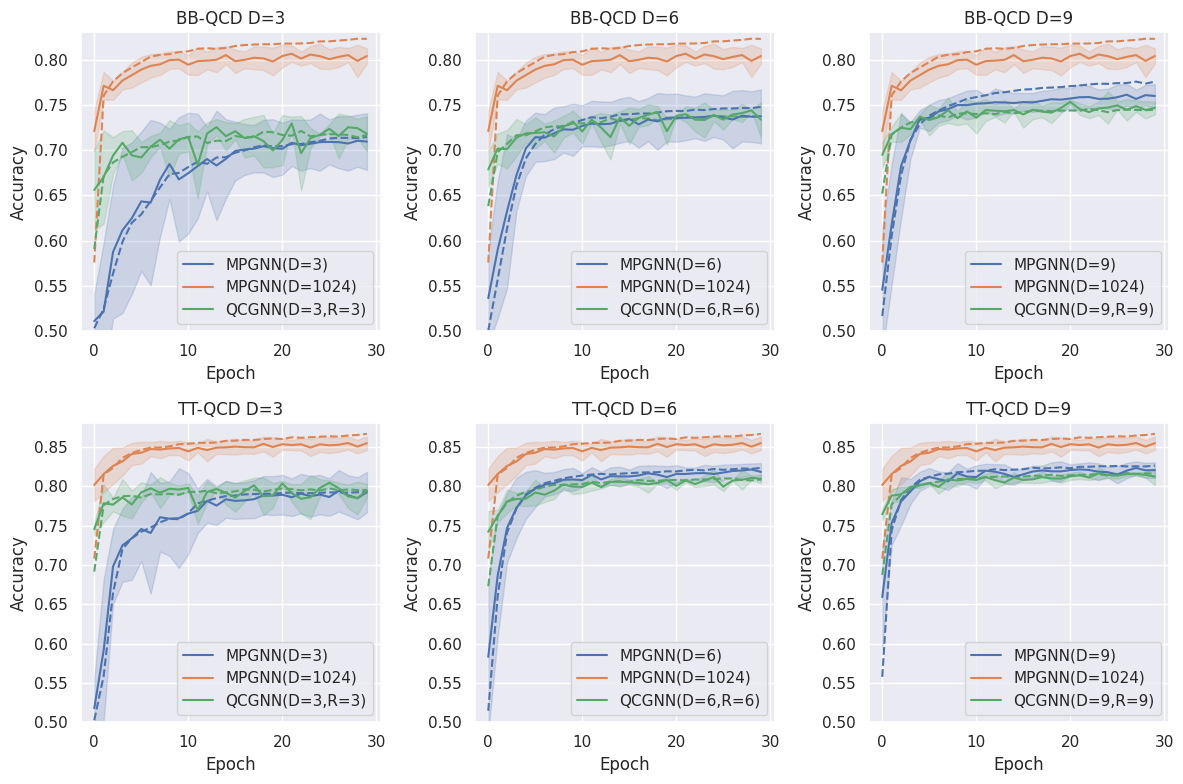

In [5]:
# `sns.errorbar`: https://seaborn.pydata.org/tutorial/error_bars.html

abbrev_list   = ["BB-QCD", "TT-QCD"]
out_dim_list  = [3,6,9]
num_r, num_c  = len(abbrev_list), len(out_dim_list)
fig, ax       = plt.subplots(num_r, num_c, figsize=(4*num_c,4*num_r))
color_palette = sns.color_palette(n_colors=3)

for row, col in product(range(num_r), range(num_c)):
    abbrev  = abbrev_list[row]
    out_dim = out_dim_list[col]
    idx_a   = (data_frame["abbrev"] == abbrev)
    idx_c   = (data_frame["gnn_out"] == best_classical["gnn_out"]) | (data_frame["gnn_out"] == out_dim)
    idx_q   = (data_frame["gnn_nn_qubits"]==out_dim) & (data_frame["gnn_reupload"]==out_dim)
    idx     = idx_a & (idx_c | idx_q)
    sns.lineplot(data_frame[idx], x="epoch", y="train_acc_epoch", hue="legend", ax=ax[row][col], palette=color_palette, err_style=None, legend=False, linestyle='--')
    sns.lineplot(data_frame[idx], x="epoch", y="valid_acc_epoch", hue="legend", ax=ax[row][col], palette=color_palette, errorbar=("sd", 1))


    ax[row][col].set_xlabel("Epoch")
    ax[row][col].set_ylabel("Accuracy")
    ax[row][col].set_title(f"{abbrev_list[row]} D={out_dim_list[col]}")

    if abbrev == "BB-QCD":
        ax[row][col].set_ylim(0.50, 0.83)
    elif abbrev == "TT-QCD":
        ax[row][col].set_ylim(0.50, 0.88)

    sns.move_legend(ax[row][col], "lower right", title=None)
    plt.tight_layout()